In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.linalg import block_diag
sns.set_theme(style="darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.vae_models import CVAE
import src.experiment_lib as experiment_lib
from src.forecasting_metrics import *

In [4]:
config_dir = 'runs/forecast/'
config_folder = 'sweep_Nov29_16-39-01/'
config = json.load(open(config_dir + config_folder +'config.json', 'r'))

In [5]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=1000
Mean of enrolments: 0.31
Number of Training Points...............1493743
Number of Testing Points................498590
Number of Validation Points.............498455
Number of Missing Points.................2162
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_44


In [6]:
model = CVAE(input_dim=trainset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(os.path.join(config_dir, config_folder))
model.eval()
pass

USING SIGMA_LIM!
USING SIGMA_LIM!


In [7]:
torch.cuda.empty_cache()
import gc
gc.collect()

30

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.prior_params = {key: value.to(device) for key, value in model.prior_params.items()}

In [9]:
log_space = config["data"]["scaling"]["log_space"]
zero_id = config["data"]["scaling"]["zero_id"]
shift = config["data"]["scaling"]["shift"]

In [10]:
num_users = user_ids["train"][-1]+1

num_test_days = int(X_test.shape[0]/num_users)

In [11]:
user_idx = 550

In [12]:
X_test_user = np.reshape(X_test , (num_users, num_test_days, -1))[[user_idx]].reshape(-1, X_test.shape[1])
conditions_user = {key: np.reshape(val, (num_users, num_test_days, -1))[[user_idx]].reshape(-1, val.shape[1]) for key, val in condition_set["test"].items()}
test_conditions = torch.tensor(conditioner.transform(conditions_user).astype(np.float32)).to(device)

In [13]:
num_prior_samples = 500
test_batch_size = 2**8
num_batches = int(np.ceil(test_conditions.shape[0] / test_batch_size))
estimation_params = {"mu":torch.zeros(num_prior_samples, num_test_days, model.input_dim), "sigma":torch.zeros(num_prior_samples, num_test_days, model.decoder.parameterizer.block_dict["sigma"].output_dim)}
estimation_samples = torch.zeros(num_prior_samples, num_test_days, model.input_dim)
log_likelihoods = torch.zeros(num_prior_samples, num_test_days)


In [14]:
flag=True

In [15]:
pbar = tqdm(total=num_prior_samples)

for i in range(num_batches):
    
    if i == num_batches-1: batch_indices = np.arange(i*test_batch_size, test_conditions.shape[0], dtype=int)
    else: batch_indices = np.arange(i*test_batch_size, (i+1)*test_batch_size, dtype=int)

    # batch_conditions = test_conditions[batch_indices]
    x_test = torch.tensor(X_test_user[batch_indices]).to(device)
    
    if flag:
        condition_batch = {k: v[batch_indices] for k,v in conditions_user.items()}
        for j in range(num_prior_samples):
            pbar.update(len(batch_indices))
            with torch.no_grad():
                batch_conditions = torch.tensor(conditioner.transform(condition_batch)).float()
                estimation = model.sample(batch_conditions.to(device), num_samples_prior=1)
                estimation_params["mu"][j, batch_indices] = estimation["params"]["mu"].detach().to("cpu")
                estimation_params["sigma"][j, batch_indices] = estimation["params"]["sigma"].detach().to("cpu")
                estimation_samples[j, batch_indices] = estimation["samples"].detach().squeeze(0).to("cpu")
                log_likelihoods[j, batch_indices] = model.decoder.log_likelihood(x_test, estimation["params"]).detach().to("cpu").float()
    else:
        pbar.update(len(batch_indices)*num_prior_samples)
        with torch.no_grad():
            estimation = model.sample(test_conditions[batch_indices].to(device), num_samples_prior=num_prior_samples)
            estimation_params["mu"][:, batch_indices] = estimation["params"]["mu"].detach().to("cpu")
            estimation_params["sigma"][:, batch_indices] = estimation["params"]["sigma"].detach().to("cpu")
            estimation_samples[:, batch_indices] = estimation["samples"].detach().squeeze(0).to("cpu")
            log_likelihoods[:, batch_indices] = model.decoder.log_likelihood(x_test, estimation["params"]).detach().to("cpu").float()

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
estimation_params["mu"] = estimation_params["mu"].numpy()
estimation_params["sigma"] = estimation_params["sigma"].numpy()
estimation_samples = estimation_samples.numpy()
log_likelihoods = log_likelihoods.numpy()

In [17]:
quantiles = [0.05, 0.10, 0.25, 0.40, 0.50, 0.60, 0.75, 0.90, 0.95]

In [18]:
estimation_samples_denorm = utils.zero_preserved_log_denormalize(np.maximum(estimation_samples,zero_id), nonzero_mean, nonzero_std, log_input=log_space).reshape(num_prior_samples,1,-1)

In [19]:
estimation_params_denorm = {}
estimation_params_denorm["mu"] = utils.zero_preserved_log_denormalize(estimation_params["mu"], nonzero_mean, nonzero_std, log_input=log_space).reshape(num_prior_samples,1,-1)

estimation_params["mu"] = estimation_params["mu"].reshape(num_prior_samples,1,-1,model.input_dim)
estimation_params["sigma"] = estimation_params["sigma"].reshape(num_prior_samples,1,-1,model.decoder.parameterizer.block_dict["sigma"].output_dim)

In [20]:
quantiles_test = np.quantile(np.maximum(estimation_samples,zero_id), quantiles, axis=0)
quantiles_test_denorm = utils.zero_preserved_log_denormalize(quantiles_test, nonzero_mean, nonzero_std, log_input=log_space)
quantiles_test = quantiles_test.reshape(len(quantiles), 1, -1)
quantiles_test_denorm = quantiles_test_denorm.reshape(len(quantiles), 1, -1)

In [21]:
X_test_denorm = utils.zero_preserved_log_denormalize(X_test_user, nonzero_mean, nonzero_std, log_input=log_space).reshape(1,-1)

In [22]:
X_test_denorm

array([[170., 161., 158., ..., 223., 172., 171.]])

In [23]:
start_day = 25
end_day = 35

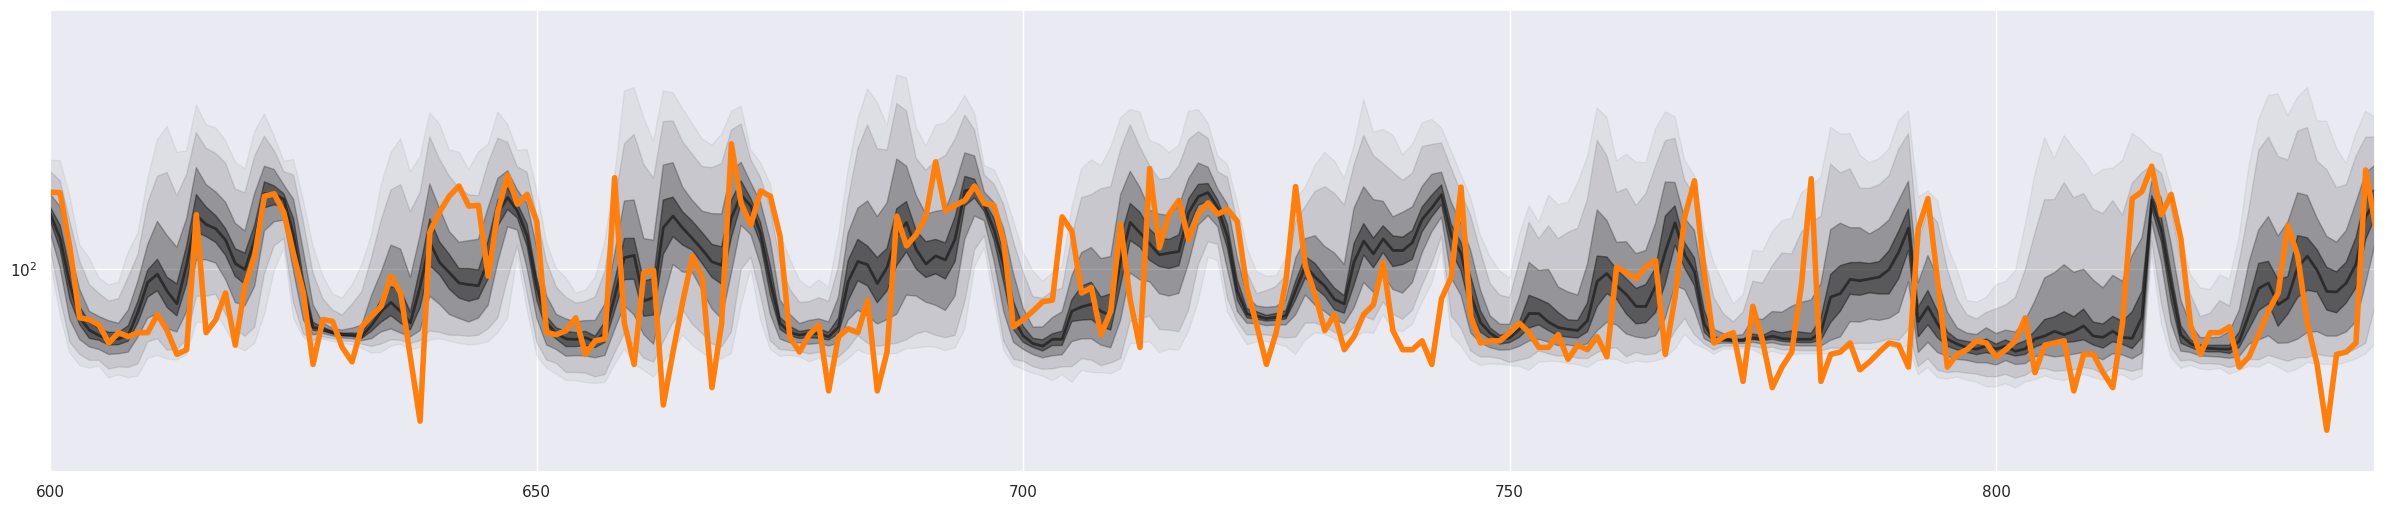

In [24]:
fig, ax = plt.subplots(figsize=(30, 6))
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(quantiles_test_denorm.shape[-1]),quantiles_test_denorm[i,0,:], quantiles_test_denorm[-(i+1),0,:], alpha=1*quantiles[i], color="black")
ax.plot(quantiles_test_denorm[quantiles.__len__()//2,0,:], label="Predicted", color="black", lw=2, alpha=0.5)

ax.plot(X_test_denorm[0], label="True", lw=4, alpha=1.0, color="tab:orange")
# ax.plot(np.concatenate((X_test_denorm[user_idx][-24:], X_test_denorm[user_idx][:-24])), label="True", lw=4, alpha=1.0, color="tab:orange") 
ax.set_yscale("log")

plt.xlim(24*start_day, 24*end_day-1)
plt.show()

In [25]:
log_likelihoods = log_likelihoods.reshape(num_prior_samples, 1, num_test_days)
closest_idx = np.argsort(log_likelihoods, axis=0)[::-1]

In [26]:
norm = 2
# distances = np.linalg.norm(estimation_samples - X_test_user, axis=-1, ord=norm).reshape(num_prior_samples, 1, num_test_days)
distances = np.linalg.norm(np.reshape(estimation_samples_denorm - X_test_denorm, (num_prior_samples, num_test_days, -1)), axis=-1, ord=norm).reshape(num_prior_samples, 1, num_test_days)
closest_idx_distance = np.argsort(distances, axis=0)

In [27]:
num_viz_samples = 1
best_indices = closest_idx[:num_viz_samples,0,:]
median_best_indices = closest_idx[(num_prior_samples-num_viz_samples)//2:(num_prior_samples+num_viz_samples)//2,0,:]
best_indices_distance = closest_idx_distance[:num_viz_samples,0,:]
median_best_indices_distance = closest_idx_distance[(num_prior_samples-num_viz_samples)//2:(num_prior_samples+num_viz_samples)//2,0,:]

In [28]:
with torch.no_grad():
    cov_matrices_median = model.decoder.create_covariance_matrix({"mu": torch.tensor(estimation_params["mu"]).to(device), "sigma": torch.tensor(np.take_along_axis(estimation_params["sigma"][:,0], median_best_indices[...,None], axis=0)).to(device)}).cpu().numpy()
    cov_matrices_best = model.decoder.create_covariance_matrix({"mu": torch.tensor(estimation_params["mu"]).to(device), "sigma": torch.tensor(np.take_along_axis(estimation_params["sigma"][:,0], best_indices[...,None], axis=0)).to(device)}).cpu().numpy()
    marginal_sigmas_median = np.sqrt(np.diagonal(cov_matrices_median, axis1=-2, axis2=-1))
    marginal_sigmas_best = np.sqrt(np.diagonal(cov_matrices_best, axis1=-2, axis2=-1))
    corr_matrices_median = cov_matrices_median / (marginal_sigmas_median[...,:,None,:] * marginal_sigmas_median[...,None])
    corr_matrices_best = cov_matrices_best / (marginal_sigmas_best[...,:,None,:] * marginal_sigmas_best[...,None])

In [29]:
devs = [0.25, 0.5, 1, 1.5, 2]

dependency_lookaway = 6

In [30]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.6)

/tmp/ipykernel_3138848/2321809344.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar


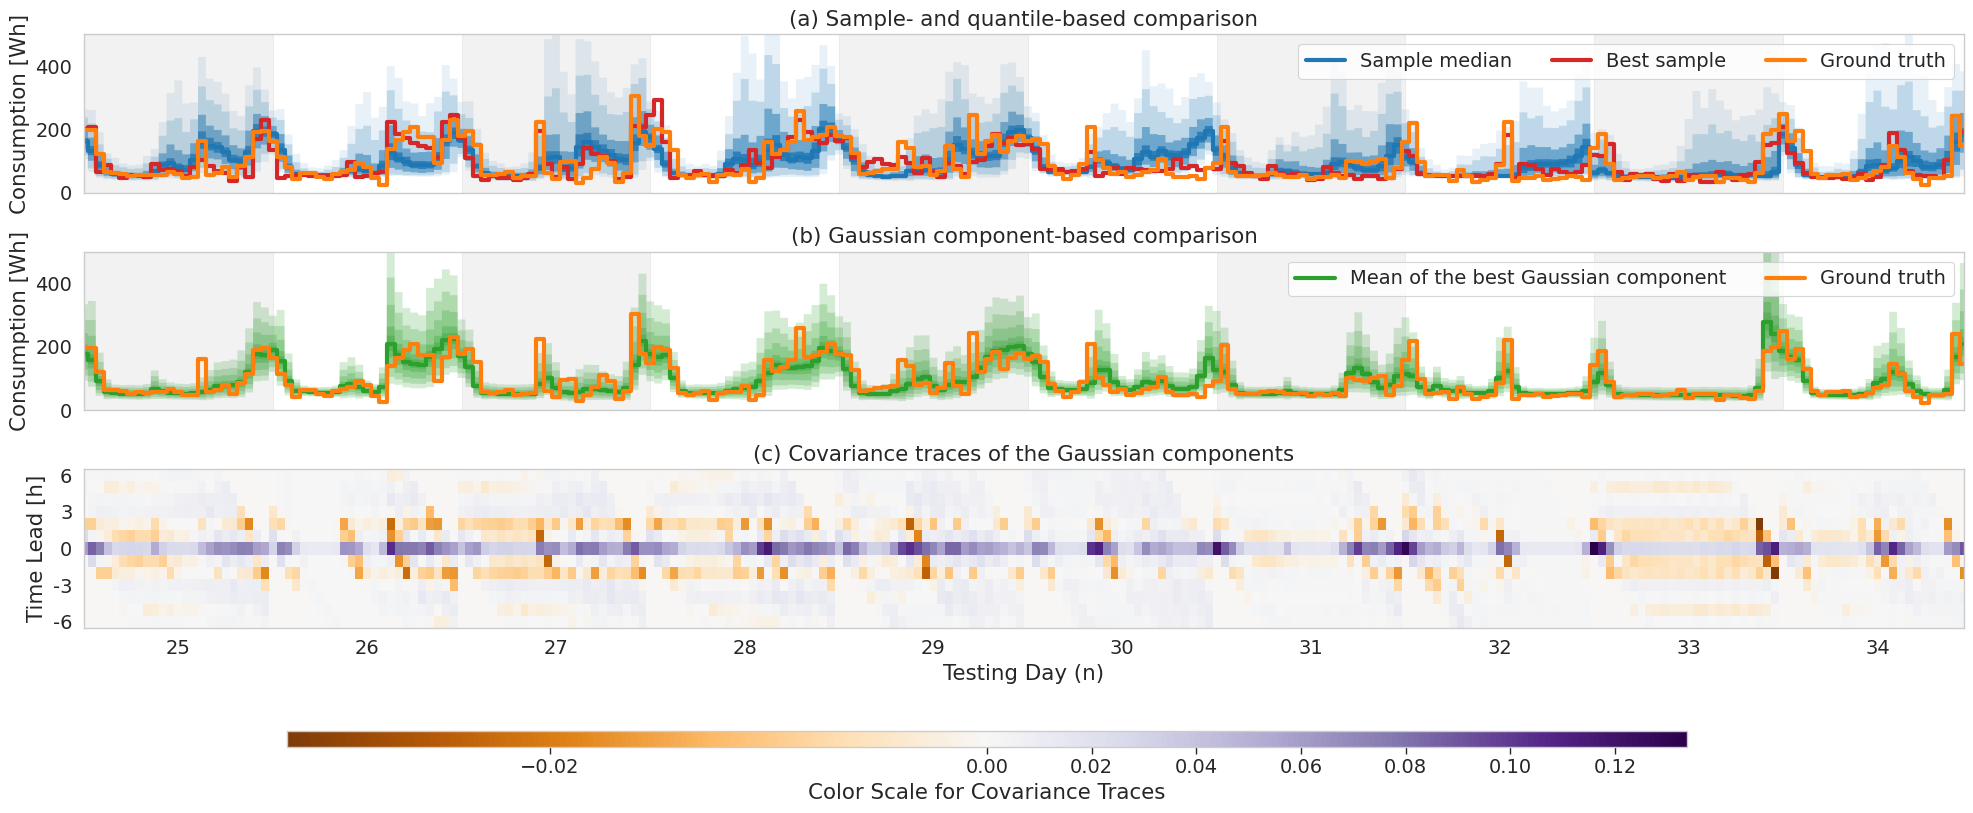

In [31]:
fig, ax = plt.subplots(3,figsize=(20, 8), sharex=True)
# fig.tight_layout()


for q in range(quantiles.__len__()//2):  ax[0].fill_between(np.arange(quantiles_test_denorm.shape[-1]),quantiles_test_denorm[q,0,:], quantiles_test_denorm[-(q+1),0,:], alpha=(2*quantiles[q])**(1/1.0), color="tab:blue", lw=0, step="mid")


for i in range(num_viz_samples):
    selected_sample = np.take_along_axis(estimation_samples_denorm[:,0].reshape(num_prior_samples,num_test_days,-1), best_indices_distance[[i]][...,None], axis=0).reshape(-1)

    selected_mu_denorm = np.take_along_axis(estimation_params_denorm["mu"][:,0].reshape(num_prior_samples,num_test_days,-1), best_indices[[i]][...,None], axis=0)
    selected_mu = np.take_along_axis(estimation_params["mu"][:,0], best_indices[[i]][...,None], axis=0)

    # ax[0].plot(selected_mu_denorm.reshape(-1), label="Best estimation", lw=2, alpha=1, color="tab:green")
    for dev in devs:
        lower_bound = utils.zero_preserved_log_denormalize(selected_mu-dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        upper_bound = utils.zero_preserved_log_denormalize(selected_mu+dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        ax[1].fill_between(np.arange(lower_bound.shape[-1]), lower_bound, upper_bound, alpha=1/(dev+3), color="tab:green", lw=0, step="mid")
    
ax[0].step(np.arange(quantiles_test_denorm.shape[-1]),quantiles_test_denorm[quantiles.__len__()//2,0,:], label="Sample median", color="tab:blue", lw=3, alpha=1, where="mid")
ax[0].step(np.arange(selected_sample.shape[0]), selected_sample, where="mid", lw=3, alpha=1, color="tab:red", label="Best sample")
ax[1].step(np.arange(selected_mu_denorm.reshape(-1).shape[0]), selected_mu_denorm.reshape(-1), where="mid", lw=3, alpha=1, color="tab:green", label="Mean of the best Gaussian component")

#put a gray background every 24 hours
for i in [0,1]:
    ax[i].step(np.arange(X_test_denorm[0].shape[0]), X_test_denorm[0], where="mid", lw=3, alpha=1.0, color="tab:orange", label="Ground truth")
    ax[i].legend(loc="upper right", ncol=3)
    for j in range(start_day, end_day,2): ax[i].axvspan(24*j, 24*(j+1), color="gray", alpha=0.1)

# Create a common colormap normalization for both imshows
cmap = "PuOr"
norm = mcolors.TwoSlopeNorm(vcenter=0)

# Plot the imshow for axes 1 and 3
im = ax[2].imshow(utils.full_band(block_diag(*[cov_matrices_best[0,i_] for i_ in range(num_test_days)]), k=dependency_lookaway), 
                   cmap=cmap, aspect="auto", interpolation="nearest", norm=norm)

# Set y-ticks for axes 1 and 3
ax[2].set_yticks(np.arange(0, 2*dependency_lookaway + 1, 3))
ax[2].set_yticklabels(np.arange(-dependency_lookaway, dependency_lookaway + 1, 3)[::-1])

# Add a single horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Color Scale for Covariance Traces")

# Update axis labels and layout
ax[-1].set_xticks(np.arange(12, num_test_days * 24, 24))
ax[-1].set_xticklabels(np.arange(0, num_test_days, 1))

for i in [0,1]:
    # ax[i].set_yscale("log")
    # ax[i].set_ylim(2e1, 2e3)
    ax[i].set_ylim(0, 500)
    ax[i].set_ylabel("Consumption [Wh]")

ax[2].set_ylabel("Time Lead [h]")

titles = ["(a) Sample- and quantile-based comparison", "(b) Gaussian component-based comparison", "(c) Covariance traces of the Gaussian components"]

for i, ax_ in enumerate(ax):
    ax_.set_xlim(24 * start_day, 24 * end_day - 1)
    ax_.grid(False)
    ax_.set_title(titles[i])


ax[-1].set_xlabel("Testing Day (n)")
fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar

plt.savefig("output.png", dpi=300, bbox_inches="tight")

plt.show()